In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

In [3]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')
events_data['day'] = events_data['date'].dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


(array([735842., 735964., 736085., 736208., 736330., 736450., 736573.,
        736695., 736815.]), <a list of 9 Text major ticklabel objects>)

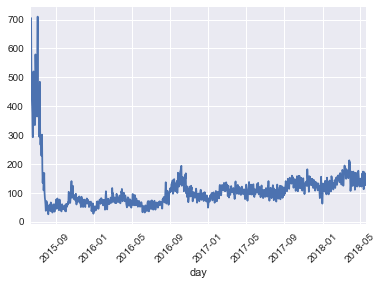

In [5]:
events_data.groupby('day')['user_id'].nunique().plot()
plt.xticks(rotation=45)

Исключены пользователи, которые не прошли ни одного степа!

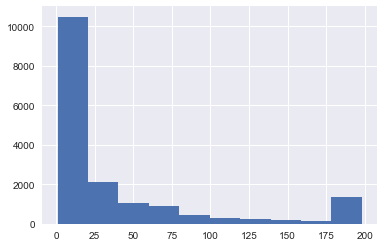

In [15]:
events_data[events_data['action'] == 'passed'].groupby(
    'user_id', as_index=False).agg({'step_id': 'count'}).rename(columns={'step_id':'passed_steps'}).passed_steps.hist()

Все пользователи :) - данные по действиям со степами

In [19]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


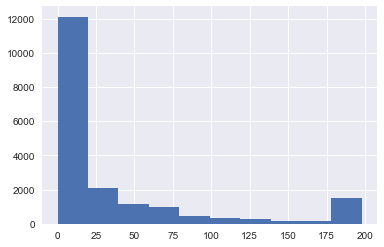

In [20]:
users_events_data['discovered'].hist()

In [6]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
submissions_data['date'] = pd.to_datetime(submissions_data['timestamp'], unit='s')
submissions_data['day'] = submissions_data['date'].dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [8]:
# число правильных и неправильных решений для каждого юзера
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index()

In [9]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [10]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).groupby(
    'user_id')['timestamp'].apply(list).apply(np.diff).values

In [11]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [12]:
gap_data = gap_data / (24 * 60 * 60)

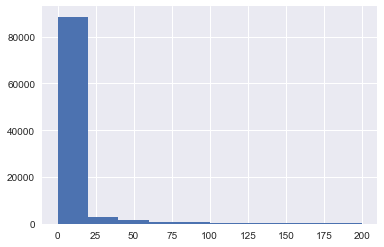

In [13]:
gap_data[gap_data < 200].hist()

Анатолий Карпов (автор курса) в таблице №1046 (кусочек кода - решение степа с вопросом)

In [14]:
events_data[(events_data['step_id'] == max(events_data['step_id'])) & (events_data['action'] == 'passed')][
    ['step_id', 'timestamp', 'user_id']].sort_values('timestamp')

,step_id,timestamp,user_id
1780990,158433,1485263664,1046
1781275,158433,1485271669,3931
1781402,158433,1485276014,14985
1782093,158433,1485288441,10626
1782261,158433,1485292242,3876
...,...,...,...
3478762,158433,1526744472,19147
3479191,158433,1526750524,13751
3479506,158433,1526754540,19491
3479620,158433,1526755659,2058


Все, продолжаем.
Будем считать, что человек покинул курс, если он уже 30 дней не активен и еще не набрал баллов на сертификат

In [28]:
users_data = events_data.groupby('user_id', as_index=False).agg(
    {'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [16]:
now = 1526772811 # дата выгрузки данных (типа это сейчас)
drop_out_threshold = 30 * 24 * 60 * 60 

Делаем датафрейм, где для каждого юзера указано, ушел он или нет, и данные по степам

In [29]:
users_data['is_gone_user'] = (now - users_data['last_timestamp']) > drop_out_threshold
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [30]:
users_data = users_data.merge(users_events_data, how = 'outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


добавим данные по тому, сколько дней человек был активен на курсе

In [31]:
users_days = events_data.groupby('user_id')['day'].nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')

Добавим колонку: прошел/не прошел курс (будем считать, что это те, кто решил хотя бы 175 степов - см. график)

In [34]:
users_data['passed_course'] = users_data['passed'] > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Проверим, что все юзеры из изначальных данных представлены в users_data

In [24]:
users_data['user_id'].nunique() == events_data['user_id'].nunique()

True

За сколько в среднем люди проходят курс (из тех, кто доходит до конца)

In [35]:
users_data[users_data['passed_course']]['day'].median()

20.0

Когда юзер в первые что-то сделал на курсе

In [38]:
user_min_time = events_data.groupby('user_id', as_index=False).agg(
    {'timestamp' : 'min'}).rename({'timestamp' : 'min_timestamp'}, axis=1)
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Давайте отберем только те наблюдения, которые для каждого юзера попадают в окно из трех дней (с момента, когда он первый раз зашел на курс)

In [39]:
# служебная колонка ("сшили" user_id и timestamp)
events_data['user_timestamp'] = events_data['user_id'].map(str) + '_' + events_data['timestamp'].map(str)
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [42]:
# в какой момент мы будем пытаться предсказать, уйдет юзер с курса или нет? - ну, возьмем три дня
learning_time_threshold = 3 * 24 * 60 * 60

# служебная колонка (для каждого юзера его порог - три дня с начала прохождения курса)
user_min_time['user_learning_time_threshold'] = user_min_time['user_id'].map(str) + '_' + (
    user_min_time['min_timestamp'] + learning_time_threshold).map(str)
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_timestamp,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [45]:
# ура! наконец-то можем отобрать нужные наблюдения (строки можно так сравнивать, да)
# на этом будем обучать модель
events_data_train = events_data[events_data['user_timestamp'] <= events_data['user_learning_time_threshold']]

снова кусочек - решение степа с вопросом

In [46]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [51]:
max_timestamp = submissions_data.groupby('user_id', as_index=False).agg(
    {'timestamp' : 'max'}).rename({'timestamp' : 'max_timestamp'}, axis=1)
submissions_data = submissions_data.merge(max_timestamp, how='outer')
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1479734163
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1479734163
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,1479734163
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,1479734163
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1479734163


In [69]:
step_dropped = submissions_data[(submissions_data['timestamp'] == submissions_data['max_timestamp']) & (
    submissions_data['submission_status'] == 'wrong')].groupby('step_id').size()
step_dropped[step_dropped == max(step_dropped)]

step_id
31978    154
dtype: int64

возвращаемся... проделаем то же самое с submissions_data

In [72]:
submissions_data['user_timestamp'] = submissions_data['user_id'].map(str) + '_' + submissions_data['timestamp'].map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[
    submissions_data['user_timestamp'] <= submissions_data['user_learning_time_threshold']]

проверим, что все правильно с числом дней

In [76]:
# events_data_train.groupby('user_id')['day'].nunique().max()
submissions_data_train.groupby('user_id')['day'].nunique().max()

4

In [135]:
# в X соберем данные для обучения модели
X = submissions_data_train.groupby('user_id')['day'].nunique().to_frame().reset_index().rename(columns={'day' : 'days'})
steps_tried = submissions_data_train.groupby('user_id')['step_id'].nunique().to_frame().reset_index().rename(
    columns={'step_id' : 'steps_tried'})
X = X.merge(steps_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [136]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index())
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [137]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index(), how='outer')
X = X.fillna(0)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9,9,2,9
1,3,1.0,4.0,4.0,4.0,0.50,15,15,4,20
2,8,1.0,11.0,9.0,21.0,0.30,109,84,37,154
3,14,1.0,1.0,0.0,1.0,0.00,4,3,1,9
4,16,3.0,23.0,23.0,27.0,0.46,55,55,26,132


In [138]:
X = X.merge(users_data[['is_gone_user', 'passed_course', 'user_id']], how='outer')
X = X[~((X['is_gone_user'] == False) & (X['passed_course'] == False))]

y = X['passed_course'].map(int)

X = X.drop(['is_gone_user', 'passed_course'], axis=1)
X = X.set_index(X['user_id'])
X = X.drop('user_id', axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
user_id,,,,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9,9,2,9
3,1.0,4.0,4.0,4.0,0.50,15,15,4,20
8,1.0,11.0,9.0,21.0,0.30,109,84,37,154
14,1.0,1.0,0.0,1.0,0.00,4,3,1,9
16,3.0,23.0,23.0,27.0,0.46,55,55,26,132


In [ ]:
X.to_csv('X_data.csv') # X - это независимые переменные (см. выше)
y.to_csv('y_data.csv') # y - это зависимая переменная: уйдет (y = 1) или не уйдет (y = 0) человек с курса за первые три дня

попробую (я) обучить дерево решений

In [142]:
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score

In [143]:
clf = tree.DecisionTreeClassifier()
grid_search_cv = GridSearchCV(clf, {'criterion' : ['gini', 'entropy'], 'max_depth' : range(1, 100)}, cv=5)

In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [145]:
grid_search_cv.fit(X_train, Y_train)
best_clf = grid_search_cv.best_estimator_

In [146]:
Y_pred = best_clf.predict(X_test)
precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)

(0.4697986577181208, 0.16587677725118483)

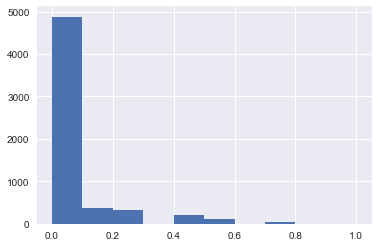

In [162]:
Y_pred_prob = best_clf.predict_proba(X_test)
pd.Series(Y_pred_prob[:,1]).hist() # распределение вероятности того, что человек уйдет (y = 0)

подкорректируем порог вероятности для предсказаний того, что человек уйдет, в соответствии с графиком выше =>  
=> ближе к балансу между precision и recall

In [175]:
Y_pred_tuned = np.where(Y_pred_prob[:, 1] > 0.25, 1, 0)
precision_score(Y_test, Y_pred_tuned), recall_score(Y_test, Y_pred_tuned)

(0.3481989708404803, 0.48104265402843605)

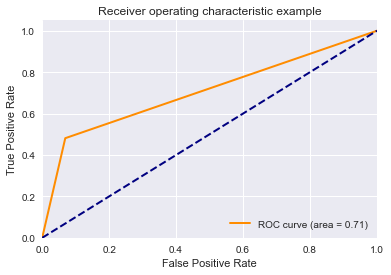

In [176]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_tuned)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()